In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from multiprocessing import Pool
from datetime import datetime
%matplotlib inline
import inputModule as ctreader
import sys
from skimage import io, feature, exposure, transform, draw, color

In [6]:
annotations = pd.read_csv('/storage/huybq/downloads/annotations.csv')
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [5]:
filePath = "/storage/shared/luna_data/"
fileName = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860"
fileExtensionName = ".mhd"
medpyIMG = ctreader.CTScan(filePath + fileName+ fileExtensionName)
medpyIMG.getOrigin()

(-157.67773, -311.67773, -438.4)

In [ ]:
candidates = pd.read_csv('/storage/huybq/downloads/candidates.csv')
candidates.head()

In [6]:
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

In [7]:
def normalizePlanes2img ( medpyImg , mode) :
    maxHU = 200.
    minHU = -800.
    medpyImg = ( medpyImg - minHU ) / ( maxHU - minHU )
    medpyImg[medpyImg > 1] = 1.
    if(mode == "solid"):
        medpyImg[medpyImg < 0.3] = 0.
    else:
        medpyImg[medpyImg < 0] = 0.
    medpyImg = (medpyImg * 255 // 1).astype(np.uint8)
    return np.asarray(medpyImg)

In [8]:
def formatPlanes ( medpyImg ) :
    for i in range(medpyImg.shape[0]):
        for j in range(medpyImg.shape[1]):
            medpyImg[i,j] = checkState(medpyImg[i,j])
    return medpyImg

In [9]:
def getPatch (medpyImg ,coordinate):
    x = int(coordinate[0])
    y = int(coordinate[1])
    z = int(coordinate[2])
    return medpyImg[max(0,x - 32) : min(511,x + 33),max(0,y - 32) : min(511,y + 33),z]

In [10]:
def checkState(hUnit):
    if hUnit < -750:
        return 0
    if hUnit >= -750 and hUnit <= -300:
        return 1
    if hUnit > -300 and hUnit < -200:
        return 2
    if hUnit >= -200 and hUnit <= 200:
        return 3
    return 4

In [ ]:
def classify (patch, coordX, coordY):
    queue = np.asarray([[coordX,coordY]])
    crossed = np.zeros(patch.shape,dtype=bool)
    crossed[coordX,coordY] = True
    non_solid_pixel = part_solid_pixel = solid_pixel = 0
    directions = np.array([(-1,0),(0,-1),(0,1),(1,0)])
    while queue.size > 0:
        X,Y = queue[0]
        queue = np.delete(queue,0,axis=0)
        state = checkState(patch[X,Y])
        if state == 0 or state == 4:
            continue
        if state == 1:
            non_solid_pixel += 1
        if state == 2:
            part_solid_pixel += 1
        if state == 3:
            solid_pixel += 1
        for direction in directions:
            newX = X + direction[0]
            newY = Y + direction[1]
            if newX < 0 or newY < 0 or newX > 63 or newY > 63:
                continue
            if crossed[newX,newY] == False:
                queue = np.vstack([queue,np.asarray([newX,newY])])
                crossed[newX,newY] = True
    return non_solid_pixel,part_solid_pixel,solid_pixel

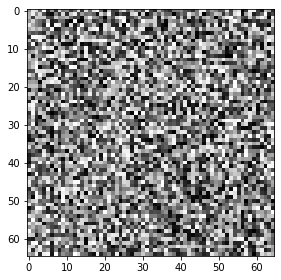

In [28]:
# load candidates
# get candidates
for index,row in annotations.iterrows():
    if index == 2:
        fileName = row["seriesuid"]
        medpyIMG = ctreader.CTScan(filePath + fileName+ fileExtensionName)
        #print(voxelCoord)
        #print(row["diameter_mm"]/medpySpacing[0],row["diameter_mm"])
        medpyOrigin,medpySpacing = medpyIMG.getOrigin(),medpyIMG.getSpacing()
        coord = worldToVoxelCoord(np.asarray([row['coordX'],row['coordY'],row['coordZ']]),medpyOrigin,medpySpacing)
        wholePatch = getPatch(medpyIMG.getData(),coord)
        io.imshow(ctreader.CTScan.hu2png(wholePatch))
        #img = getPatch(medpyImg,512,[256,256,voxelCoord[2]])
#         diffutionImg = smoothing.anisotropic_diffusion(normalizePlanes2img(wholePatch,"non-solid"),niter = 10, kappa = 2, gamma = 0.0625,voxelspacing = None, option = 3)
    #         ax.set(title=str(row["diameter_mm"]/medpySpacing[0]))
    #         im = ax.imshow(wholePatch,cmap='RdBu',interpolation='nearest')
    #         if index == 0 :
    #             fig.colorbar(im, ax=ax)
    #         fig.show()
        #fig.savefig("/storage/huybq/downloads/patches-heatmap-HU/colorMap"+str(indxtex)+".png")
        #non_solid_pixel,part_solid_pixel,solid_pixel = classify(wholePatch,voxelWidth//2,voxelWidth//2)
        #print(non_solid_pixel,part_solid_pixel,solid_pixel)
        #io.imshow(hu2png(img,-800),cmap = plt.cm.gray)
        #io.imshow(rotated)
        #printio.imsave("/storage/huybq/downloads/patches-500-HU/"+str(index)+".png",hu2png(wholePatch,-500))
        #printio.imsave("/storage/huybq/downloads/patches-800-HU/"+str(index)+".png",hu2png(wholePatch,-800))
        #define solid,part-solid as 1
        #define non-solid as 0
        break

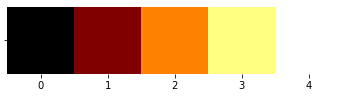

In [4]:
array = [[0,1,2,3,4]]
plt.figure(linewidth=0.3)
heatmap = sns.heatmap(array, cmap ='afmhot',square=True,cbar = False)
heatmap.yaxis.set_ticklabels('')
plt.savefig('/storage/huybq/LIDC/figure/colormap.png',edgecolor='black',bbox_inches = 'tight',pad_inches = 0.006,dpi = 360)

In [7]:
metadata = pd.read_csv('/storage/huybq/LIDC/csvData/metadata.csv')
metadata.head()

,fileName,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy,diameter,surface_area,volume,avail32,avail64,height,width
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,4,1,6,4,4,1,2,5,3,19.500000,1135.239277,2621.823750,True,True,27,28
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,5,1,6,3,4,1,1,5,3,20.840585,1124.125177,2439.303750,False,True,34,27
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,4,1,5,5,5,1,1,5,1,5.076662,66.910605,62.107500,True,True,8,7
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...,5,1,4,3,5,2,3,5,4,23.300483,1650.898027,4332.315000,False,True,35,35
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168...,3,1,6,5,5,5,5,5,5,12.683877,505.336348,803.854584,True,True,18,14


In [41]:
data = metadata[['fileName','texture']].to_numpy()
Path = '/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'
# for name in names:
#     img = io.imread(huLocationFile+fileName+'.tiff')
#     img = color.rbga2rgb(img)
#     io.imsave(huLocationFile+fileName+'.tiff',img)
#     gray_img = io.imread(greyLocationFile+fileName+'.tiff')
#     mask = np.zeros((64,64,4),dtype=np.uint8)
#     rr,cc = draw.disk((31.5,31.5),32)
#     mask[rr,cc] = 1
#     for angle in range(0,360,15):
#         rotated = transform.rotate(img*mask,angle,resize=(64,64,3))
#         io.imsave(rotatedFilePath+fileName+"_rotate_"+str(angle)+'.tiff',rotated,check_contrast = False)

In [ ]:
def shape_check(fileName,texture):
    level = 360
    if texture < 3:
        level = 40
    if texture == 3:
        level = 24
    for angle in range(0,360,level):
        img = io.imread(greyRotateLocationFile+fileName+"_rotate_"+str(angle)+'.png')
        if img.shape != (64,64):
            print(fileName)

In [2]:
def flip(img):
    return np.fliplr(img)
def img_rotate_generator(fileName, texture, x64 = True):
    if x64 :
#       source image
        img = io.imread('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'.png')
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
            io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'.png',img)
        grey_img = io.imread('/storage/huybq/LIDC/lidc_image/grey/grey_64/'+fileName+".png")
#       flip image 
        img_flip = flip(img)
        grey_img_flip = flip(grey_img)
#       source rotated image
        img_rotate = transform.rotate(img,30,clip = True)
        grey_img_rotate = transform.rotate(grey_img,30,clip = True)
#       rotated flip image
        img_rotate_flip = transform.rotate(img_flip,30,clip = True)
        grey_img_rotate_flip = transform.rotate(grey_img_flip,30,clip = True)
#       save image
        io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'_flip.png',img_flip)
        io.imsave('/storage/huybq/LIDC/lidc_image/grey/grey_64/'+fileName+'_flip.png',grey_img_flip, check_contrast = False)
        io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'_rotate.png',img_rotate)
        io.imsave('/storage/huybq/LIDC/lidc_image/grey/grey_64/'+fileName+'_rotate.png',grey_img_rotate, check_contrast = False)
        io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'_flip_rotate.png',img_rotate_flip)
        io.imsave('/storage/huybq/LIDC/lidc_image/grey/grey_64/'+fileName+'_flip_rotate.png',grey_img_rotate_flip, check_contrast = False)
    else:
        img = io.imread('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_32/'+fileName+'.png')
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
            io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_32/'+fileName+'.png',img)
        grey_img = io.imread('/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+".png")
#       flip image 
        img_flip = flip(img)
        grey_img_flip = flip(grey_img)
#       source rotated image
        img_rotate = transform.rotate(img,30,clip = True)
        grey_img_rotate = transform.rotate(grey_img,30,clip = True)
#       rotated flip image
        img_rotate_flip = transform.rotate(img_flip,30,clip = True)
        grey_img_rotate_flip = transform.rotate(grey_img_flip,30,clip = True)
#       save image
        io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_32/'+fileName+'_flip.png',img_flip)
        io.imsave('/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+'_flip.png',grey_img_flip, check_contrast = False)
        io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_32/'+fileName+'_rotate.png',img_rotate)
        io.imsave('/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+'_rotate.png',grey_img_rotate, check_contrast = False)
        io.imsave('/storage/huybq/LIDC/lidc_image/heatmap/heatmap_32/'+fileName+'_flip_rotate.png',img_rotate_flip)
        io.imsave('/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+'_flip_rotate.png',grey_img_rotate_flip, check_contrast = False)

In [10]:
def remove_redundancies(fileName, texture, x64 = True):
    if x64:
        Path = '/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'.png'
        flipPath = '/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'_flip.png'
        rotatePath = '/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'_rotate.png'
        flipRotatePath = '/storage/huybq/LIDC/lidc_image/heatmap/heatmap_64/'+fileName+'_flip_rotate.png'
    else:
        Path = '/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+'png'
        flipPath = '/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+'_flip.png'
        rotatePath = '/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+'_rotate.png'
        flipRotatePath = '/storage/huybq/LIDC/lidc_image/grey/grey_32/'+fileName+'_flip_rotate.png'
    if os.path.exists(Path):
        img = io.imread(Path)
        if(img.shape[2] == 4):
            print(img.shape)
    if os.path.exists(flipPath):
        img = io.imread(flipPath)
        if(img.shape[2] == 4):
            print(img.shape)
    if os.path.exists(rotatePath):
        img = io.imread(rotatePath)
        if(img.shape[2] == 4):
            print(img.shape)
    if os.path.exists(flipRotatePath):
        img = io.imread(flipRotatePath)
        if(img.shape[2] == 4):
            print(img.shape)
for name,texture in data64:
    remove_redundancies(name,texture)

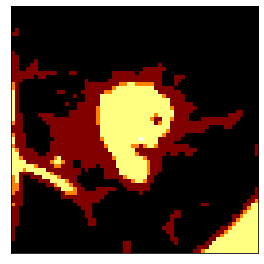

In [42]:
for name,texture in data:
    if texture == 3:
        img = io.imread(Path+name+'.png')
        io.imshow(img)
        plt.xticks(ticks=[],labels=[])
        plt.yticks(ticks=[],labels=[])
        plt.savefig('/storage/huybq/LIDC/figure/heatmap.png',dpi=360,bbox_inches='tight')
        break

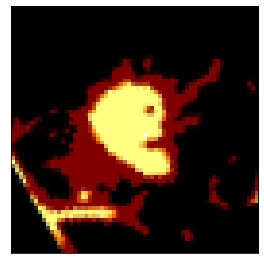

In [43]:
for name,texture in data:
    if texture == 3:
        img = io.imread(Path+name+'_rotate.png')
        io.imshow(img)
        plt.xticks(ticks=[],labels=[])
        plt.yticks(ticks=[],labels=[])
        plt.savefig('/storage/huybq/LIDC/figure/heatmap_rotate.png',dpi=360,bbox_inches='tight')
        break

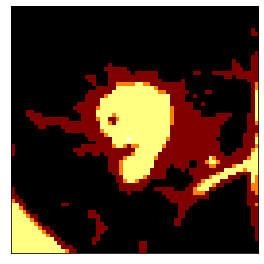

In [44]:
for name,texture in data:
    if texture == 3:
        img = io.imread(Path+name+'_flip.png')
        io.imshow(img)
        plt.xticks(ticks=[],labels=[])
        plt.yticks(ticks=[],labels=[])
        plt.savefig('/storage/huybq/LIDC/figure/heatmap_flip.png',dpi=360,bbox_inches='tight')
        break

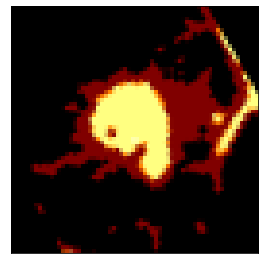

In [45]:
for name,texture in data:
    if texture == 3:
        img = io.imread(Path+name+'_flip_rotate.png')
        io.imshow(img)
        plt.xticks(ticks=[],labels=[])
        plt.yticks(ticks=[],labels=[])
        plt.savefig('/storage/huybq/LIDC/figure/heatmap_flip_rotate.png',dpi=360,bbox_inches='tight')
        break

In [ ]:
def imgTiff2PNG(name):
    img = io.imread(huLocationFile+name+'.tiff')
    io.imsave('/storage/huybq/LIDC/LIDC_heatmap_segmented_64x64_png/'+name+'.png',img)
    img = transform.resize(img,(256,256,3))
    io.imsave('/storage/huybq/LIDC/LIDC_heatmap_segmented_64x64_to_256x256_png/'+name+'.png',img)
    gray_img = io.imread(greyLocationFile+name+'.tiff')
    io.imsave('/storage/huybq/LIDC/LIDC_grey_64x64_png/'+name+'.png',gray_img.astype(np.uint8))
    gray_img = transform.resize(gray_img,(256,256))
    io.imsave('/storage/huybq/LIDC/LIDC_grey_64x64_to_256x256_png/'+name+'.png',gray_img.astype(np.uint8))

In [4]:
metadata = pd.read_csv('/storage/huybq/LIDC/csvData/metadata.csv')
metadata32 = metadata.drop(metadata.loc[metadata['avail32'] == False].index)
data32 = metadata32[['fileName','texture']].to_numpy()
metadata64 = metadata.drop(metadata.loc[metadata['avail64'] == False].index)
data64 = metadata64[['fileName','texture']].to_numpy()

In [15]:
arr = np.unique(data64[:,1], return_counts = True)
arr

(array([1, 2, 3, 4, 5], dtype=object), array([ 450,  106,  414,  285, 1911]))

In [5]:
start = datetime.now()
p = Pool(processes=24)
p.starmap(remove_redundancies, [(name,texture) for (name,texture) in data64]) #[name for name in data])
p.close()
p.join()
print(datetime.now() - start)
start = datetime.now()
p = Pool(processes=24)
p.starmap(remove_redundancies, [(name,texture,False) for (name,texture) in data32]) #[name for name in data])
p.close()
p.join()
print(datetime.now() - start)

0:00:00.511272
0:00:00.511201


In [ ]:
img = io.imread(huLocationFile+'1.3.6.1.4.1.14519.5.2.1.6279.6001.807635771657676107005923650811_nodule_0_anno_0.tiff')
#img_rotate_generator('1.3.6.1.4.1.14519.5.2.1.6279.6001.807635771657676107005923650811_nodule_0_anno_0')
# grey_mask = np.zeros((64,64,3),dtype=np.uint8)
# rr,cc = draw.disk((31.5,31.5),32)
# grey_mask[rr,cc] = 1
rotated = transform.rotate(img,45,clip=True)
io.imshow(rotated)
#io.imsave('/storage/huybq/LIDC/test.png',rotated,check_contrast=False)